In [1]:
import glob # To read file names
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#-- Useful functions:

#-- Training-Test Plots:
def TT_Curves(n_epoch, loss_train, loss_test, f1_train, f1_test, fname):
    fig = plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    fig.suptitle('Training and Test Curves', fontsize=22)
    plt.plot(range(n_epoch), loss_train, label='Train')
    plt.plot(range(n_epoch), loss_test, label='Test')
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.legend(loc=7, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid()
    plt.subplot(1,2,2)
    plt.plot(range(n_epoch), f1_train, label='Train')
    plt.plot(range(n_epoch), f1_test, label='Test')
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel(r'$f_1$ Score', fontsize=18)
    plt.legend(loc=7, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid()
    plt.savefig(fname)
    plt.show()

#-- Confusion Matrix Plots:
def Conf_Matrix(cm, score, tit, fname):
    plt.figure(figsize=(9,9))
    plt.title(tit, fontsize = 22)
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = "RdYlGn", cbar=True, annot_kws={"fontsize":25, "color":"k"});
    plt.ylabel('Data', fontsize=18)
    plt.xlabel('Prediction', fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    all_sample_title = 'Accuracy Score: {0}'.format(format(score, ".3f"))
    plt.savefig(fname)
    plt.show()
    plt.clf()

#-- Multi-Layer Perceptron model:
def MLP_process(model, n_epoch, x_train, y_train, x_test, y_test, optimizer, criterion):
    #-- Training lists:
    loss_train = np.zeros(n_epoch)
    f1_train = np.zeros(n_epoch)
    
    #-- Test lists:
    loss_test = np.zeros(n_epoch)
    f1_test = np.zeros(n_epoch)
    
    #-- Train inputs:
    x_train_tensor = torch.from_numpy(x_train)
    y_train_tensor = torch.from_numpy(y_train)
    #-- Test inputs:
    x_test_tensor = torch.from_numpy(x_test)
    y_test_tensor = torch.from_numpy(y_test)
    
    #-- Iteration process:
    for epoch in range(n_epoch):
        model.train()
        y_pred = model(x_train_tensor.float())
        
        loss = criterion(y_pred, y_train_tensor)
        loss_train[epoch] = loss.item()
        
        y_pred = torch.argmax(y_pred, 1)
        f1_train[epoch] = f1_score(y_train, y_pred, average='macro')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #print(f'Epoch [{epoch+1}/{n_epoch}], loss: {loss_train[-1]}, f1:{f1_train[-1]}')
        
        model.eval()
        
        y_pred = model(x_test_tensor.float())
        loss = criterion(y_pred, y_test_tensor)
        loss_test[epoch] = loss.item()
        
        y_pred = torch.argmax(y_pred, 1)
        f1_test[epoch] = f1_score(y_test, y_pred, average='macro')
    
    return loss_train, loss_test, f1_train, f1_test

In [3]:
#-- Data files names:
File_names = glob.glob('Manudata/*.csv')
File_names.sort()
File_names

['Manudata/bkg1.csv',
 'Manudata/bkg1_img_dat.csv',
 'Manudata/bkg1signal250.csv',
 'Manudata/bkg2.csv',
 'Manudata/bkg2_img_dat.csv',
 'Manudata/bkg2signal350.csv',
 'Manudata/bkg3.csv',
 'Manudata/bkg3_img_dat.csv',
 'Manudata/bkg3signal1000.csv',
 'Manudata/signal1000.csv',
 'Manudata/signal1000_img_dat.csv',
 'Manudata/signal250.csv',
 'Manudata/signal250_img_dat.csv',
 'Manudata/signal350.csv',
 'Manudata/signal350_img_dat.csv']

In [4]:
#-- Data in 1, 4, 7, 10, 12 and 14 entries of File_names

#-- Background data: Classified as Class 0:
b1 = pd.read_csv(File_names[1], dtype=float) # bkg1
b1.drop(columns=['Unnamed: 0'], inplace=True)
b2 = pd.read_csv(File_names[4], dtype=float) # bkg2
b2.drop(columns=['Unnamed: 0'], inplace=True)
b3 = pd.read_csv(File_names[7], dtype=float) # bkg3
b3.drop(columns=['Unnamed: 0'], inplace=True)

#-- Signal data: Classified as Class 1:
s1 = pd.read_csv(File_names[10], dtype=float) # signal: 250
s1.drop(columns=['Unnamed: 0'], inplace=True)
s2 = pd.read_csv(File_names[12], dtype=float) # signal: 350
s2.drop(columns=['Unnamed: 0'], inplace=True)
s3 = pd.read_csv(File_names[14], dtype=float) # signal: 1000
s3.drop(columns=['Unnamed: 0'], inplace=True)

#-- Reorganize data for analysis:
#-- Signal 250 with backgrounds 1, 2 and 3:
frames1 = [s1, b1.iloc[:int(len(s1.index)/3.0), :],
           b2.iloc[:int(len(s1.index)/3.0), :],
           b3.iloc[:int(len(s1.index)/3.0), :]]
#-- Signal 350 with backgrounds 1, 2 and 3:
frames2 = [s2, b1.iloc[:int(len(s2.index)/3.0), :],
           b2.iloc[:int(len(s2.index)/3.0), :],
           b3.iloc[:int(len(s2.index)/3.0), :]]
#-- Signal 1000 with backgrounds 1, 2 and 3:
frames3 = [s3, b1.iloc[:int(len(s3.index)/3.0), :],
           b2.iloc[:int(len(s3.index)/3.0), :],
           b3.iloc[:int(len(s3.index)/3.0), :]]

#-- Put data in dataframe format:
datap1 = pd.concat(frames1, ignore_index=True)
datap2 = pd.concat(frames2, ignore_index=True)
datap3 = pd.concat(frames3, ignore_index=True)

#-- Select the input data for classification MLP model:
data1, data2, data3 = datap1.iloc[:,:15], datap2.iloc[:,:15], datap3.iloc[:,:15]
#-- Select the target data for classification MLP model:
target1, target2, target3 = datap1.iloc[:,-1], datap2.iloc[:,-1], datap3.iloc[:,-1]

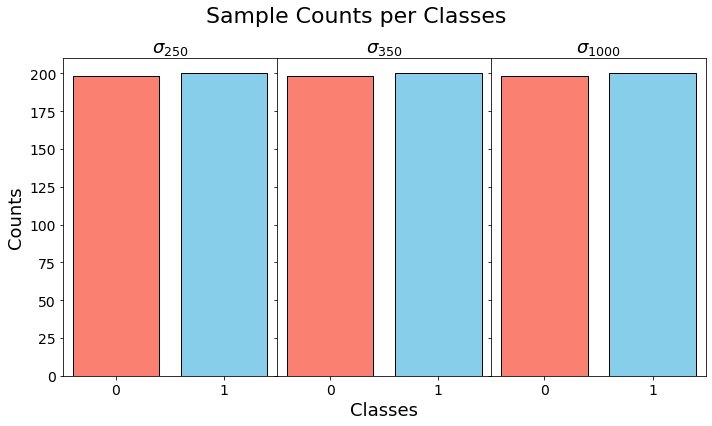

<Figure size 720x432 with 0 Axes>

In [5]:
#-- Initial data visualization:

#-- Set the figure size:
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
gs = fig.add_gridspec(1, 3, wspace=0)
(ax1, ax2, ax3) = gs.subplots(sharey='row')
fig.suptitle('Sample Counts per Classes', fontsize=22)
ax1.set_title(r'$\sigma_{250}$', fontsize=18)
ax2.set_title(r'$\sigma_{350}$', fontsize=18)
ax3.set_title(r'$\sigma_{1000}$', fontsize=18)
ax1.set_ylabel('Counts', fontsize=18)
ax2.set_xlabel('Classes', fontsize=18)
lbs1, cts1 = np.unique(target1, return_counts=True)
lbs2, cts2 = np.unique(target2, return_counts=True)
lbs3, cts3 = np.unique(target3, return_counts=True)
ax1.bar(lbs1, cts1, align='center', color=['salmon', 'skyblue'], ec='black')
ax2.bar(lbs2, cts2, align='center', color=['salmon', 'skyblue'], ec='black')
ax3.bar(lbs3, cts3, align='center', color=['salmon', 'skyblue'], ec='black')
ax1.set_xticks([0, 1], [0, 1], size=14)
ax2.set_xticks([0, 1], [0, 1], size=14)
ax3.set_xticks([0, 1], [0, 1], size=14)
ax1.tick_params(axis='y', labelsize=14)
plt.savefig('Target_Counts.png')
plt.show()
plt.clf()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

x_train1, x_test1, y_train1, y_test1 = train_test_split(data1, target1, test_size=0.25, random_state=0)
x_train2, x_test2, y_train2, y_test2 = train_test_split(data2, target2, test_size=0.25, random_state=0)
x_train3, x_test3, y_train3, y_test3 = train_test_split(data3, target3, test_size=0.25, random_state=0)

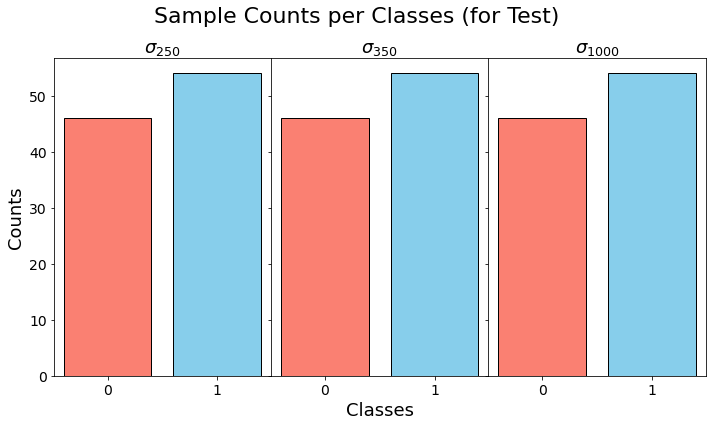

<Figure size 720x432 with 0 Axes>

In [7]:
#-- Test targets data visualization:

#-- Set the figure size:
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
gs = fig.add_gridspec(1, 3, wspace=0)
(ax1, ax2, ax3) = gs.subplots(sharey='row')
fig.suptitle('Sample Counts per Classes (for Test)', fontsize=22)
ax1.set_title(r'$\sigma_{250}$', fontsize=18)
ax2.set_title(r'$\sigma_{350}$', fontsize=18)
ax3.set_title(r'$\sigma_{1000}$', fontsize=18)
ax1.set_ylabel('Counts', fontsize=18)
ax2.set_xlabel('Classes', fontsize=18)
lbs1, cts1 = np.unique(y_test1, return_counts=True)
lbs2, cts2 = np.unique(y_test2, return_counts=True)
lbs3, cts3 = np.unique(y_test3, return_counts=True)
ax1.bar(lbs1, cts1, align='center', color=['salmon', 'skyblue'], ec='black')
ax2.bar(lbs2, cts2, align='center', color=['salmon', 'skyblue'], ec='black')
ax3.bar(lbs3, cts3, align='center', color=['salmon', 'skyblue'], ec='black')
ax1.set_xticks([0, 1], [0, 1], size=14)
ax2.set_xticks([0, 1], [0, 1], size=14)
ax3.set_xticks([0, 1], [0, 1], size=14)
ax1.tick_params(axis='y', labelsize=14)
plt.savefig('Test_Target_Counts.png')
plt.show()
plt.clf()

In [8]:
#-- MLP Structure:
import torch

input_dim = 15
out_dim = 2

model1 = torch.nn.Sequential(
    torch.nn.Linear(input_dim, out_dim),
    torch.nn.ReLU()
)
model2 = torch.nn.Sequential(
    torch.nn.Linear(input_dim, out_dim),
    torch.nn.ReLU()
)
model3 = torch.nn.Sequential(
    torch.nn.Linear(input_dim, out_dim),
    torch.nn.ReLU()
)
model1, model2, model3

(Sequential(
   (0): Linear(in_features=15, out_features=2, bias=True)
   (1): ReLU()
 ),
 Sequential(
   (0): Linear(in_features=15, out_features=2, bias=True)
   (1): ReLU()
 ),
 Sequential(
   (0): Linear(in_features=15, out_features=2, bias=True)
   (1): ReLU()
 ))

In [9]:
# Optimizer and loss function:
optimizer1 = torch.optim.Adam(model1.parameters())
criterion1 = torch.nn.CrossEntropyLoss()

optimizer2 = torch.optim.Adam(model2.parameters())
criterion2 = torch.nn.CrossEntropyLoss()

optimizer3 = torch.optim.Adam(model3.parameters())
criterion3 = torch.nn.CrossEntropyLoss()

In [10]:
#-- MLP Training:
n_epoch = 600 # Epoch's number

#-- For sigma250 data:
loss_train1, loss_test1, f1_train1, f1_test1 = MLP_process(model1, n_epoch,
                                                           x_train1.to_numpy(), y_train1.to_numpy().astype('int'),
                                                           x_test1.to_numpy(), y_test1.to_numpy().astype('int'),
                                                           optimizer1, criterion1)

#-- For sigma350 data:
loss_train2, loss_test2, f1_train2, f1_test2 = MLP_process(model2, n_epoch,
                                                           x_train2.to_numpy(), y_train2.to_numpy().astype('int'),
                                                           x_test2.to_numpy(), y_test2.to_numpy().astype('int'),
                                                           optimizer2, criterion2)

#-- For sigma1000 data:
loss_train3, loss_test3, f1_train3, f1_test3 = MLP_process(model3, n_epoch,
                                                           x_train3.to_numpy(), y_train3.to_numpy().astype('int'),
                                                           x_test3.to_numpy(), y_test3.to_numpy().astype('int'),
                                                           optimizer3, criterion3)

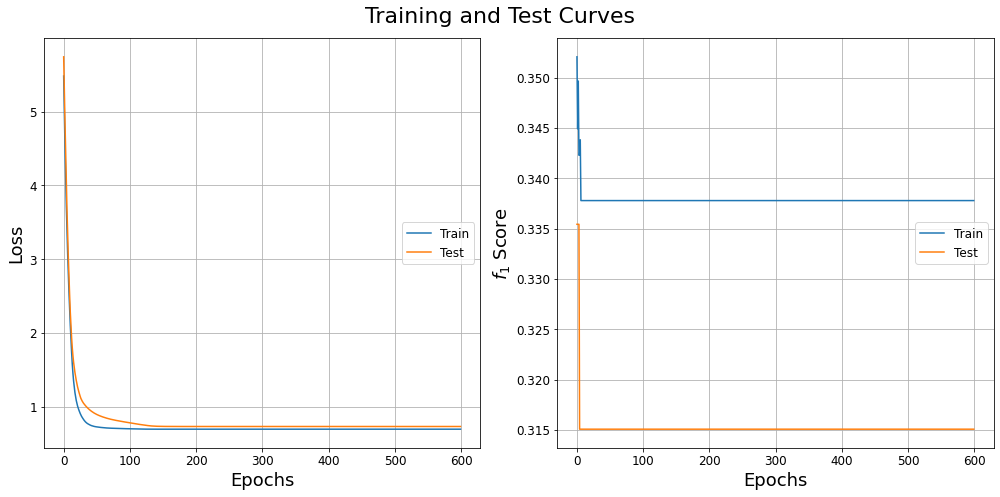

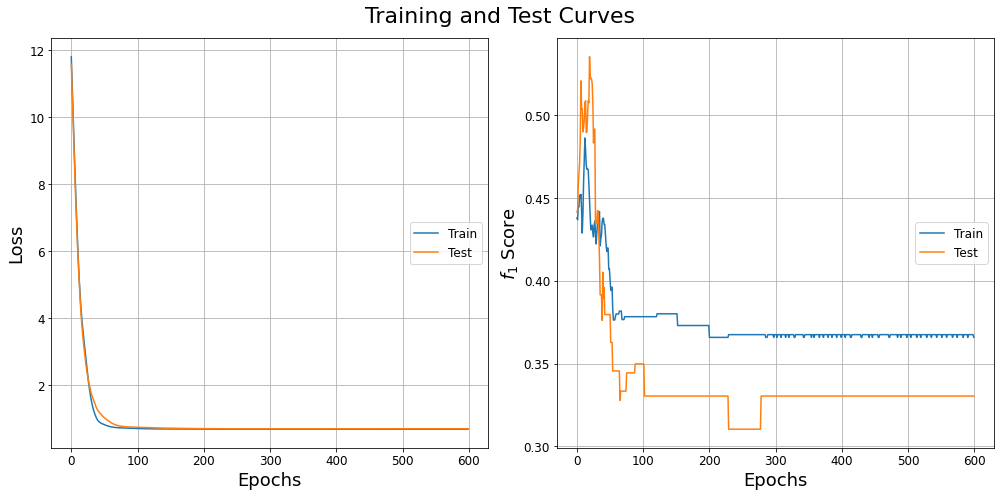

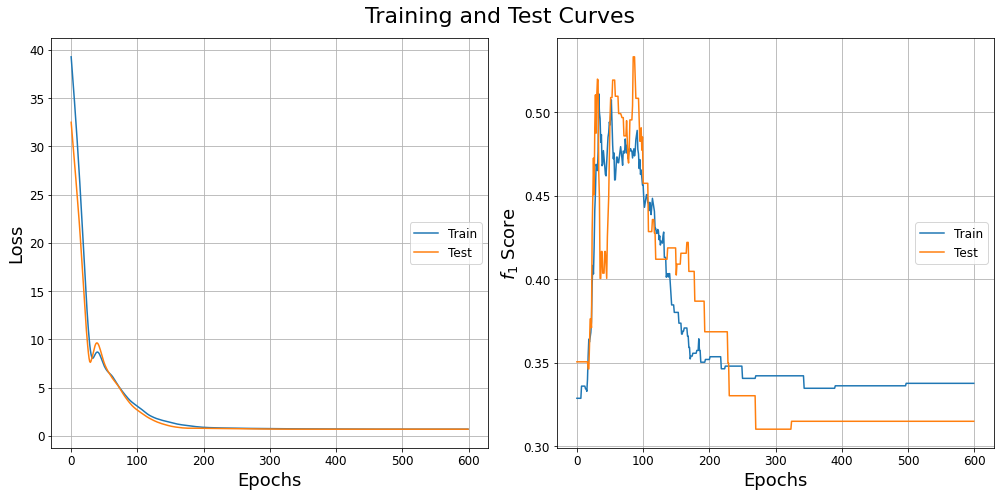

In [11]:
#-- Training and test curves:

#-- For sigma 250:
fname1 = 'sgima250_Training-Test_Curves.png'
TT_Curves(n_epoch, loss_train1, loss_test1, f1_train1, f1_test1, fname1)

#-- For sigma 350:
fname2 = 'sgima350_Training-Test_Curves.png'
TT_Curves(n_epoch, loss_train2, loss_test2, f1_train2, f1_test2, fname2)

#-- For sigma 1000:
fname3 = 'sgima1000_Training-Test_Curves.png'
TT_Curves(n_epoch, loss_train3, loss_test3, f1_train3, f1_test3, fname3)


In [12]:
#-- Minimal parameters:

#-- For sigma 250:
min_params1 = np.argmin(np.array(loss_test1)[np.array(f1_train1)<1]), min(np.array(loss_test1)[np.array(f1_train1)<1])

#-- For sigma 350:
min_params2 = np.argmin(np.array(loss_test2)[np.array(f1_train2)<1]), min(np.array(loss_test2)[np.array(f1_train2)<1])

#-- For sigma 1000:
min_params3 = np.argmin(np.array(loss_test3)[np.array(f1_train3)<1]), min(np.array(loss_test3)[np.array(f1_train3)<1])

min_params1, min_params2, min_params3

((226, 0.7297110557556152),
 (243, 0.6954810619354248),
 (324, 0.6931473016738892))

In [13]:
#-- Confusion matrix:

#-- For sigma 250:
y_pred1 = []
y_pred1 = torch.argmax(model1(torch.from_numpy(x_test1.to_numpy()).float()), 1).numpy()

#-- For sigma 350:
y_pred2 = []
y_pred2 = torch.argmax(model2(torch.from_numpy(x_test2.to_numpy()).float()), 1).numpy()

#-- For sigma 1000:
y_pred3 = []
y_pred3 = torch.argmax(model3(torch.from_numpy(x_test3.to_numpy()).float()), 1).numpy()

cm1 = metrics.confusion_matrix(y_test1, y_pred1)
cm2 = metrics.confusion_matrix(y_test2, y_pred2)
cm3 = metrics.confusion_matrix(y_test3, y_pred3)
print(cm1, cm2, cm3)

precision1 = precision_score(y_test1, y_pred1, average='micro')
precision2 = precision_score(y_test2, y_pred2, average='micro')
precision3 = precision_score(y_test3, y_pred3, average='micro')
print(precision1, precision2, precision3)

recall1 = recall_score(y_test1, y_pred1, average='micro')
recall2 = recall_score(y_test2, y_pred2, average='micro')
recall3 = recall_score(y_test3, y_pred3, average='micro')
print(recall1, recall2, recall3)

score1 = accuracy_score(y_test1, y_pred1)
score2 = accuracy_score(y_test2, y_pred2)
score3 = accuracy_score(y_test3, y_pred3)
print(score1, score2, score3)

[[46  0]
 [54  0]] [[45  1]
 [53  1]] [[46  0]
 [54  0]]
0.46 0.46 0.46
0.46 0.46 0.46
0.46 0.46 0.46


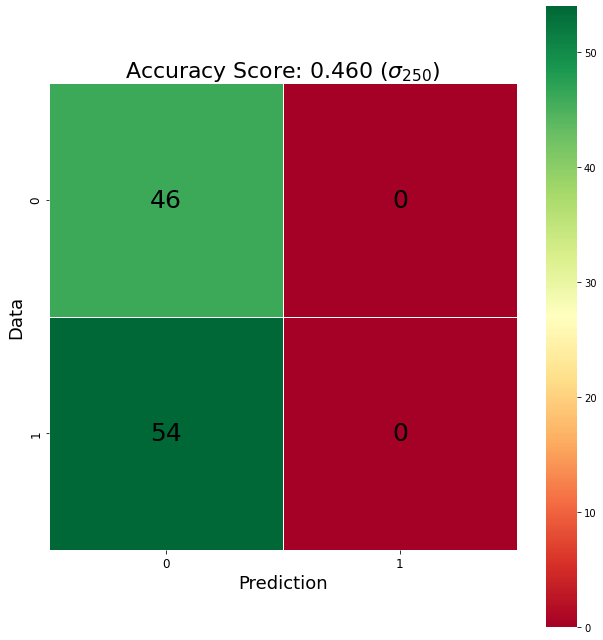

<Figure size 720x432 with 0 Axes>

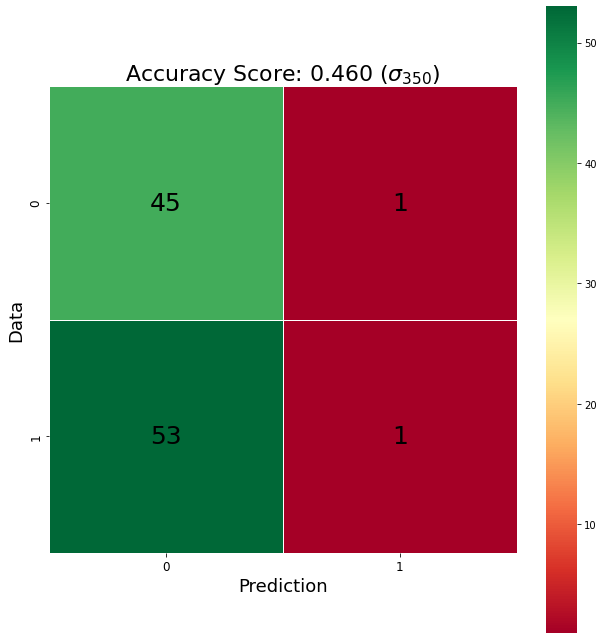

<Figure size 720x432 with 0 Axes>

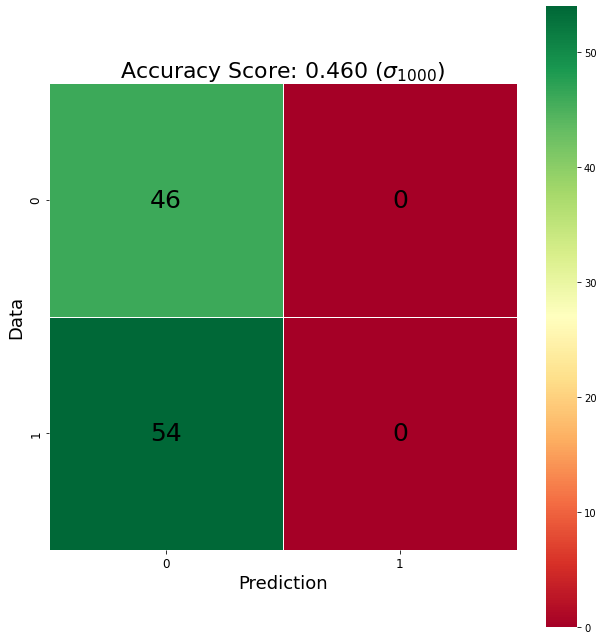

<Figure size 720x432 with 0 Axes>

In [14]:
#-- Confusion Matrix plots:

#-- For sigma 250:
Conf_Matrix(cm1, score1, r'Accuracy Score: {0}'.format(format(score1,'.3f'))+' ($\sigma_{250}$)',
            'sigma250_Conf_Mat.png')

#-- For sigma 350:
Conf_Matrix(cm2, score2, r'Accuracy Score: {0}'.format(format(score2,'.3f'))+' ($\sigma_{350}$)',
            'sigma350_Conf_Mat.png')

#-- For sigma 1000:
Conf_Matrix(cm3, score3, r'Accuracy Score: {0}'.format(format(score3,'.3f'))+' ($\sigma_{1000}$)',
            'sigma1000_Conf_Mat.png')

In [15]:
tp1, fn1, fp1, tn1 = cm1[0,0], cm1[0,1], cm1[1,0], cm1[1,1]
tp2, fn2, fp2, tn2 = cm2[0,0], cm2[0,1], cm2[1,0], cm2[1,1]
tp3, fn3, fp3, tn3 = cm3[0,0], cm3[0,1], cm3[1,0], cm3[1,1]

tpr1, fpr1 = tn1/(tn1+fp1), tp1/(tp1+fn1)
tpr2, fpr2 = tn2/(tn2+fp2), tp2/(tp2+fn2)
tpr3, fpr3 = tn3/(tn3+fp3), tp3/(tp3+fn3)

print(np.array([tpr1, tpr2, tpr3]))
print(np.array([fpr1, fpr2, fpr3]))

[0.         0.01851852 0.        ]
[1.         0.97826087 1.        ]
